## Import packages

In [1]:
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

## Define differentiable Gillespie algorithm


In [10]:
# Define the stoichiometry matrix for the reactions
stoic_matrix = torch.tensor([[2.0, 0.0],    # Reaction 1: Promoter state goes from -1 to +1
                             [0.0, 1.0],    # Reaction 2: mRNA is produced
                             [-2.0, 0.0],   # Reaction 3: Promoter state goes from +1 to -1
                             [0.0, -1.0]])  # Reaction 4: Degradation of mRNA

# Define a function to compute the state jump
def state_jump(reaction_index, stoic_matrix):
    """
    Calculate state jump vector based on the selected reaction index and stoichiometry matrix, where, 
    state vector -> state vector + state jump vector.

    Arguments:
        reaction_index: Selected reaction index
        stoic_matrix: Stoichiometry matrix

    Returns:
        State jump vector
    """
    return torch.sum(stoic_matrix * (torch.exp(-b_inv* (reaction_index - torch.arange(stoic_matrix.shape[0]))**2)).view(-1, 1), dim=0)

# Define a function to select the reaction based on reaction selection thresholds
def reaction_selection(breaks, random_num):
    """
    Select reaction based on the transition points and a random number. Transition points are 
    given by the ratio of cumulative sum of rates and the total rate.

    Arguments:
        breaks: Transition points between [0,1]
        random_num: Random number in [0,1]

    Returns:
        Index of the next reaction
    """
    return torch.sum(torch.sigmoid(a_inv * (random_num - breaks)))

# Define the Gillespie simulation function
def gillespie_simulation(kon, r, g, num_simulations, sim_time, a_inv, b_inv, c):
    """
    Perform differentiable Gillespie simulation for a 2-state promoter model.
    
    Arguments:
        kon: Rate of promoter switching from -1 to +1.
        r: Rate of mRNA production.
        g: Rate of mRNA degradation.
        num_simulations: Number of simulations to run.
        sim_time: Simulation time.
        a_inv: Inverse parameter for reaction selection.
        b_inv : Inverse parameter for state jump calculation.
        c: Sigmoid slope parameter for propensities.
        
    Returns:
        mean_final_state: Mean of the mRNA levels at the end of the simulation.
        variance: Variance of the mRNA levels at the end of the simulation.
    """
    # Initialize random seed for reproducibility
    random_seed = torch.randint(1, 10000000, (1,))
    torch.manual_seed(random_seed)
    final_states = 0.0
    final_states_squared = 0.0

    # Main simulation loop
    for j in range(num_simulations):
        # Initial 'levels':
        # The first component of 'levels' is the promoter state, initialized to -1
        # The second component of 'levels' is the mRNA level, initailized to 0.
        levels = torch.stack([torch.tensor(-1.0), torch.tensor(0.0)])
        current_time = 0.0

        # Main simulation loop
        while current_time < sim_time:
            # Calculate reaction propensities
            propensities = torch.stack([kon *torch.sigmoid(-c*levels[0]),                # Rate of promoter state switching from -1 to +1
                                        r*torch.sigmoid(-c*levels[0]),                   # Rate of mRNA production
                                        torch.tensor([1.0])*torch.sigmoid(c*levels[0]),  # Rate of promoter state switching from +1 to -1
                                        g*levels[1]])                                    # Rate of mRNA degradation

            # Calculate total propensity
            total_propensity = propensities.sum()

            # Generate a random number to determine time to next reaction
            dt = -torch.log(torch.rand(1)) / total_propensity
            current_time += dt.item()

            # Check if the simulation exceeds sim_time. If it exceeds, quit the simulation.
            if current_time >= sim_time:
                break

            # Update state
            breaks = (propensities[:-1] / total_propensity).cumsum(dim=0)
            reaction_index = reaction_selection(breaks, torch.rand(1))
            levels = levels + state_jump(reaction_index, stoic_matrix)
            levels[1] = torch.relu(levels[1]) 

        # Accumulate final states after each sumulation
        final_states += levels[1]
        final_states_squared += levels[1] ** 2

    # Calculate mean and variance of mRNA levels (from the accumulated final states)
    mean_final_state = final_states / num_simulations
    variance = final_states_squared / num_simulations - mean_final_state ** 2

    # Return mean mRNA level and variance
    return mean_final_state, variance

# Define a function to write data to a file
def write_to_file(filename, *args):
    with open(filename, 'a') as file:
        file.write(' '.join(map(str, args)) + '\n')
        
# Define the loss function 
def loss_function(mean_final_state, variance, target_mean, target_std):
    """
    Calculates the mean squared error of the simulation results against data
    """
    return (mean_final_state - target_mean) ** 2 + (variance ** 0.5 - target_std) ** 2

## Extract the learned parameters for no degeneracy case


In [11]:
# Load the data from learning progress file
file_path = '2state_model_no_deg.txt'  

data = np.loadtxt(file_path) 

# Initialize dictionaries to store the parameter values for minimum loss
min_rows = {}

# Iterate through each row in the data
for row in data:
    index = int(row[0])
    # Update the minimum row for the index as needed
    if index not in min_rows or row[-1] < min_rows[index][-1]:
        min_rows[index] = row

# Extract the parameter values for minimum loss
diff_gillespie_min = [row[[2, 3, 4, 5,6]] for row in min_rows.values()]
diff_gillespie_min = np.array(diff_gillespie_min)

## Obtain the error bars on $r$

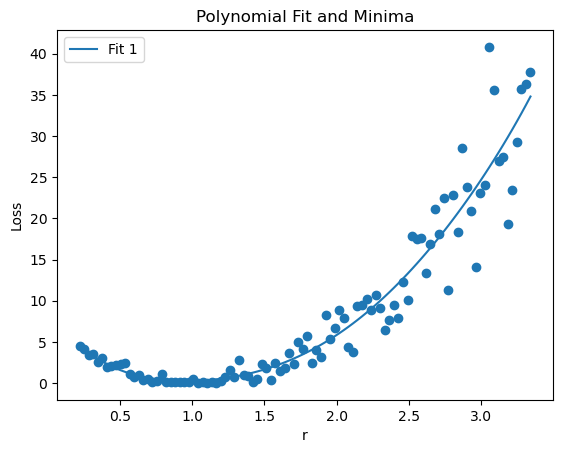

0.6086195837782564 1.1131012439727783 0.9593594430916884 0.5340530894752801 1.4451508944092386


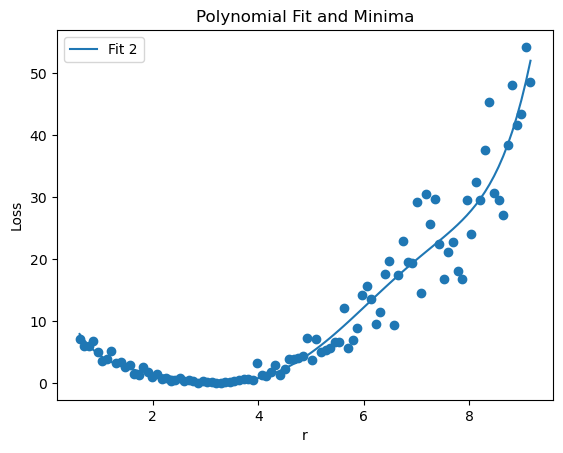

7.02426903609271 3.053983211517334 3.3722825522184365 2.33086911522059 4.119458906927038


In [ ]:
# Define the equation to solve
def equation_to_solve(p, valid_minima, std):
    return abs(poly_func(p) - poly_func(valid_minima + 1.96 * std)) - 1e-5

# Load true values
true_values = np.load("random_rates.npy")[:len(diff_gillespie_min), :]

# Define filename for saving results
filename = "error_bar_on_r_no_deg.txt"

# Remove file if it already exists
if os.path.exists(filename):
    os.remove(filename)

# Set the hyperparameters
num_points = 100
num_simulations = 50
sim_time = 10.0
a_inv=200.0
b_inv=20.0
c=20.0

torch.manual_seed(42)

for i in range(20):
    torch.manual_seed(42)
    loss_list = []
    kon, r, g, target_mean, target_std = diff_gillespie_min[i, :5]
    
    # Generate a range of r values for evaluation
    r_list = np.linspace(r - r * 0.8, r * 3, num_points)
    
    # Perform simulations and calculate losses
    for r_value in r_list:
        mean, var = gillespie_simulation(torch.tensor([kon]), torch.tensor([r_value]), torch.tensor([g]),
                                        num_simulations, sim_time, a_inv, b_inv, c)
        loss = loss_function(mean, var, target_mean, target_std)
        loss_list.append(loss.item())

    # Perform polynomial fitting
    degree = 6
    coeffs = np.polyfit(r_list, loss_list, degree)
    poly_func = np.poly1d(coeffs)
    first_derivative = np.polyder(poly_func, 1)
    second_derivative = np.polyder(poly_func, 2)
    critical_points = np.roots(first_derivative)
    
    # Filter for real roots within the range of r
    critical_points_real_in_range = [cp for cp in critical_points if np.isreal(cp) and r_list[0] <= cp.real <= r_list[-1]]

    # Convert filtered roots to real if they are within the valid range
    critical_points_real_in_range = [cp.real for cp in critical_points_real_in_range]

    # Find valid minima
    valid_minima = [cp for cp in critical_points_real_in_range if second_derivative(cp) > 0]
    valid_minima = valid_minima[0]
    
    # Determine the number of evaluation points
    num_points2 = 50

    # Generate evaluation points
    evaluation_points = np.linspace(r_list[0], r_list[-1], num_points2)

    # Evaluate curvature at each point
    curvatures = [second_derivative(point) for point in evaluation_points]

    # Compute the average curvature
    average_curvature = np.mean(curvatures)

    # Compute standard deviation based on the average curvature
    std = 1 / np.sqrt(abs(average_curvature))

    # Plot polynomial fitting
    plt.plot(r_list, poly_func(r_list), label=f'Fit {i+1}')
    plt.scatter(r_list, loss_list, marker='o')  # Display the loss points
    plt.title('Polynomial Fit and Minima')
    plt.xlabel('r')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Define bounds for fsolve
    lower_bound = 0
    upper_bound = valid_minima

    # Limit initial guess to fall within the bounds
    initial_guess = max(lower_bound, min((lower_bound + upper_bound) / 2, upper_bound))

    # Use fsolve to solve the equation
    solution, = fsolve(equation_to_solve, initial_guess, args=(valid_minima, std))

    # Write results: true r, learned r, minimum loss r, left error bar, right error bar
    write_to_file(filename, true_values[i, 1], r, valid_minima, solution, valid_minima + 1.96 * std)
    
    # Print results
    print(true_values[i, 1], r, valid_minima, solution, valid_minima + 1.96 * std)